### 초기 설정
라이브러리 불러오기

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격 - 타겟 데이터
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
    


grade : 등급과 가격에 연관성을 보임
sqft_living, sqft_living15 : 면적과 가격에 연관성을 보임
yr_renovated : 재건축을 하지 않은 집이 월등히 많았으나, 재건축을 한 집의 경우 최근에 할 수록 가격이 올라가는 경향이 있음

In [3]:
# sns.catplot(data=train, x = 'sqft_living15', y = 'price')

### 주소 지정
train, test 데이터 불러오기

In [4]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

### train data 확인

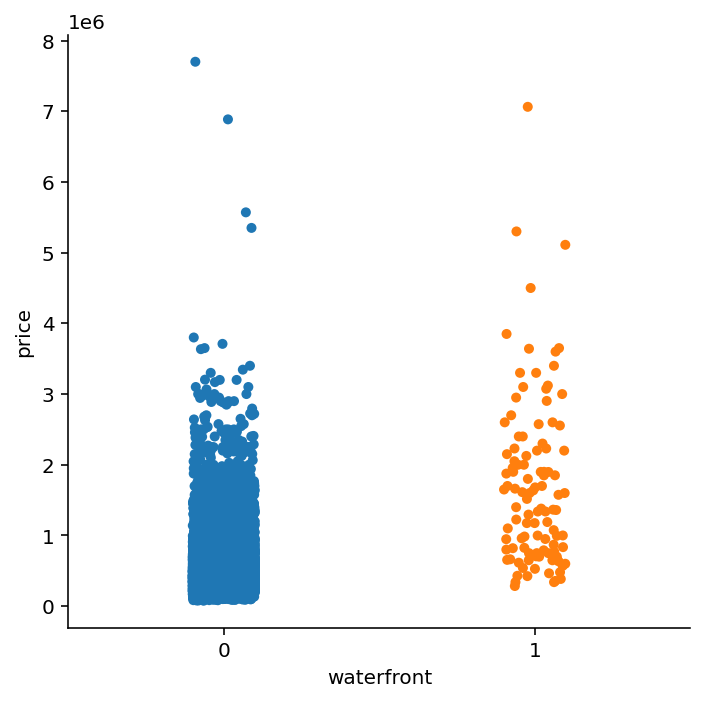

In [5]:
sns.catplot(data=train, x='waterfront', y='price')

리버뷰 차이에 따라 가격이 크게 다르지 않음 - 삭제

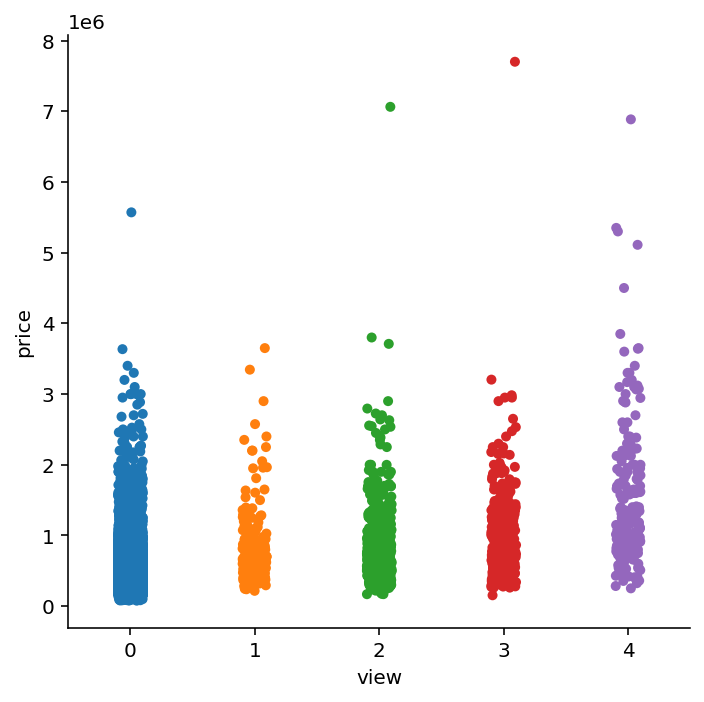

In [6]:
sns.catplot(data=train, x='view', y='price')

view의 정도에 따라 4점만 약간의 차이가 있음 - 삭졔

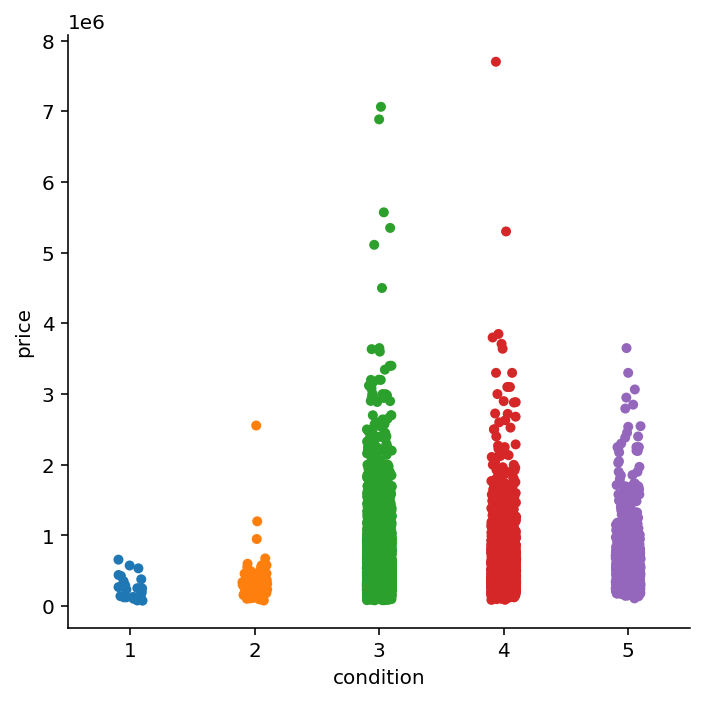

In [7]:
sns.catplot(data=train, x='condition', y='price')

3점의 가격이 가장 높음 - 삭제

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [9]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 데이터 전처리

In [10]:
# price 데이터 삭제

y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [11]:
# train 데이터와 test 데이터 합치기
# 나중에 분리하기 위해 train 길이 저장

train_len = len(train)
data = pd.concat((train, test), axis=0)

print(len(data))

21503


In [12]:
# 분석에 필요없는 id 데이터 삭제

del data['id']

In [13]:
# date 데이터 int형으로 변경

data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  int64  
 1   bedrooms       21503 non-null  int64  
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  int64  
 4   sqft_lot       21503 non-null  int64  
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  int64  
 11  sqft_basement  21503 non-null  int64  
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  int64  
 18  sqft_lo

### 결측치 확인

<AxesSubplot:>

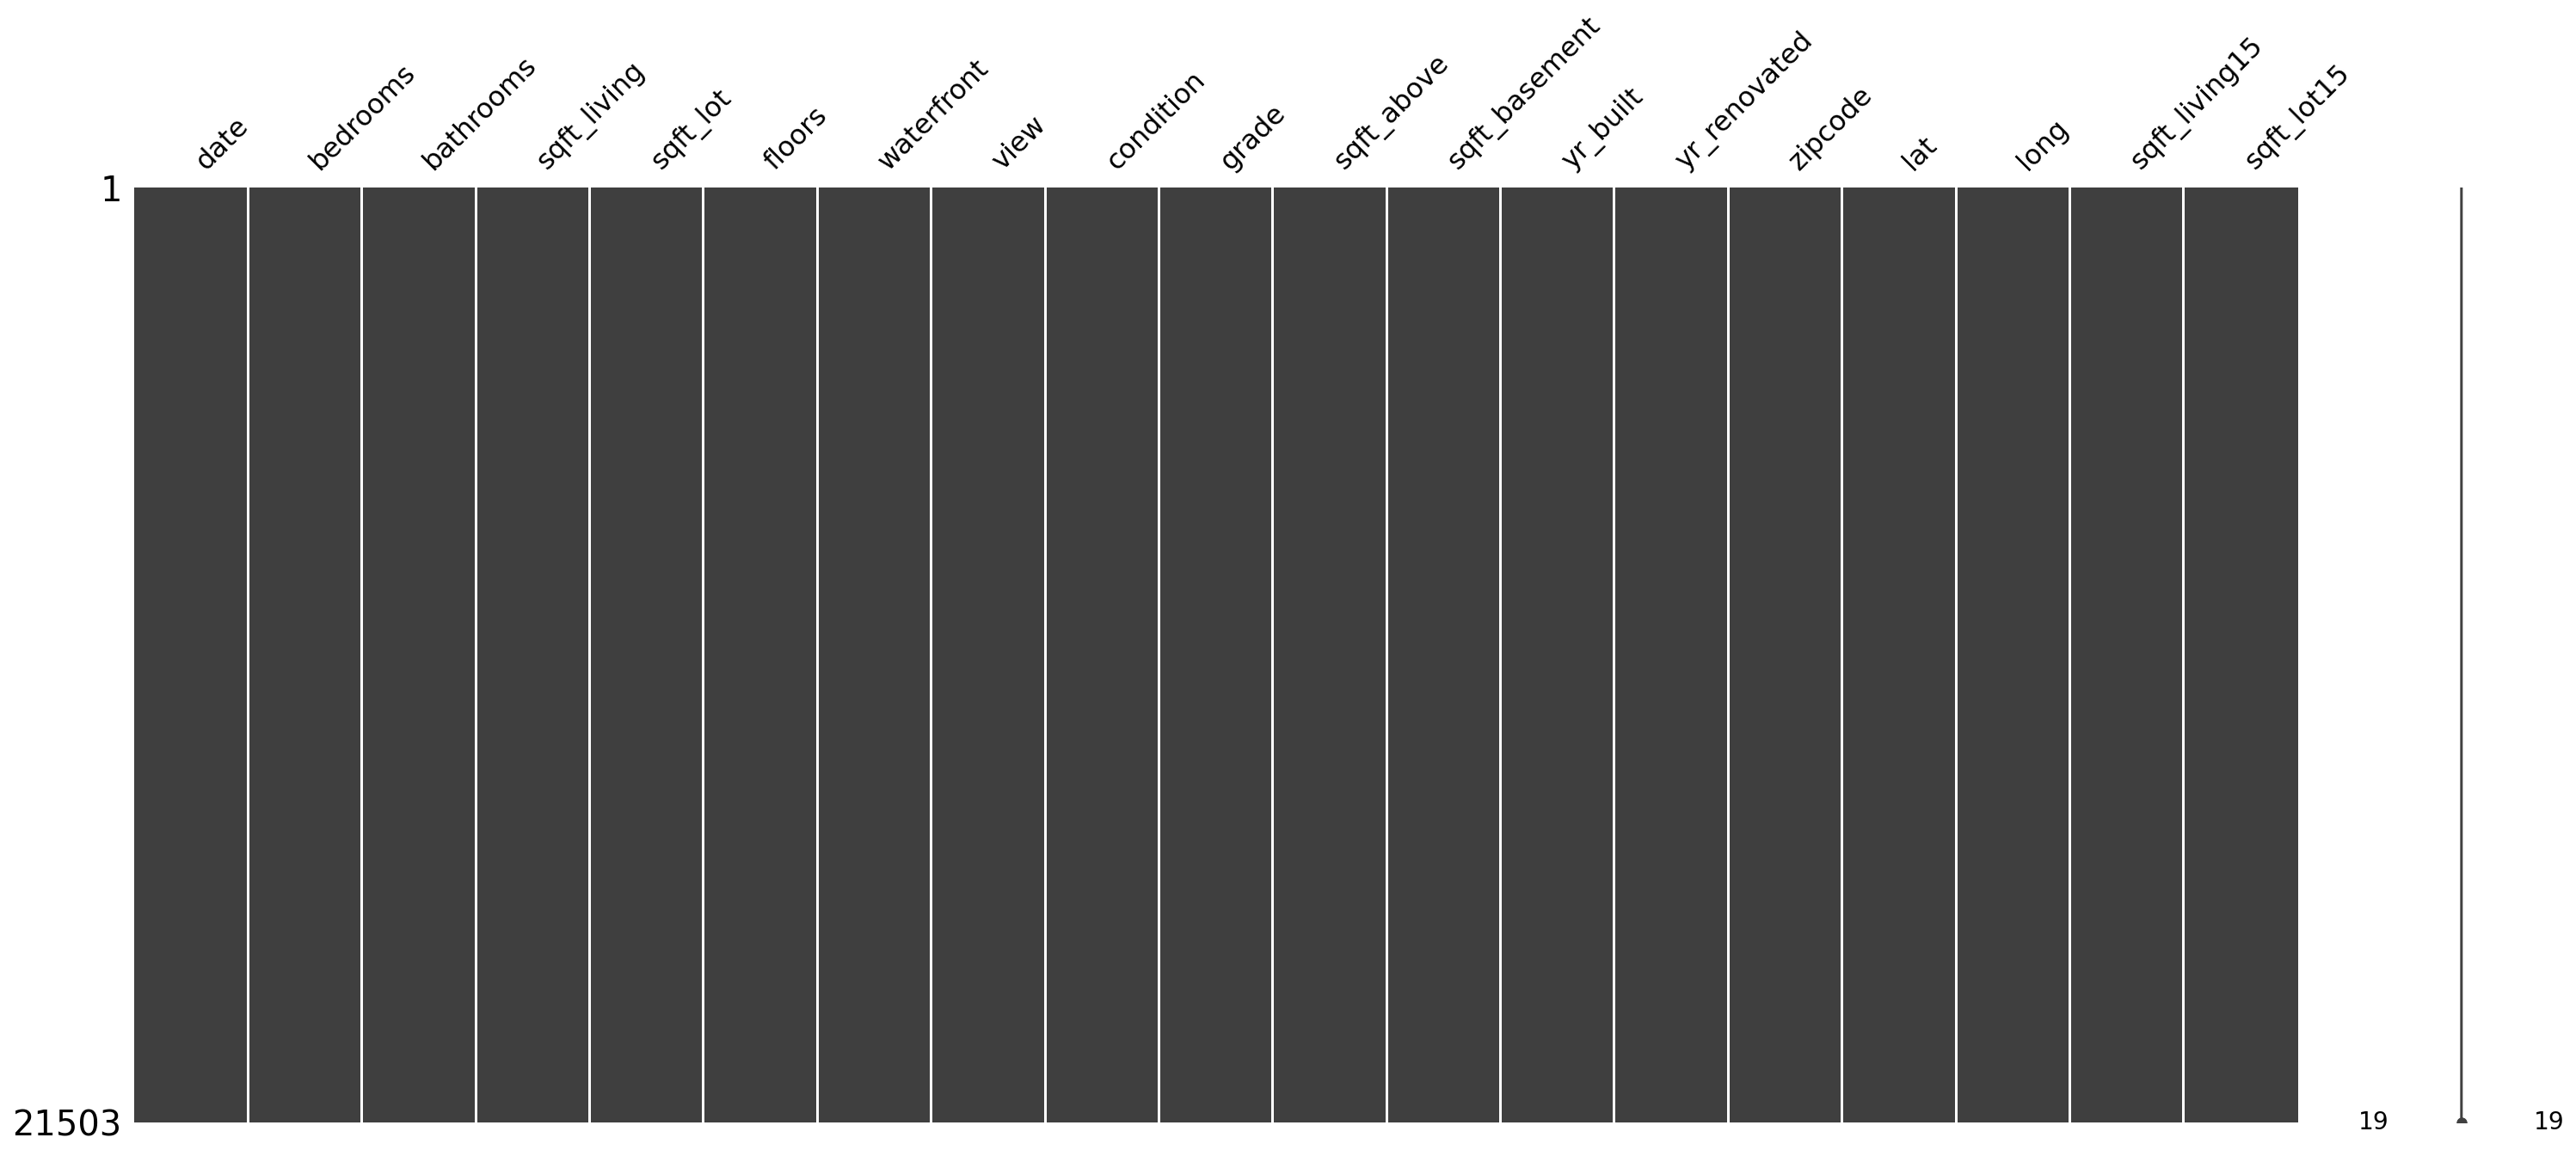

In [14]:
# mano.matrix : 매트릭스 결측치 시각화, 결측치 하얗게 표시

msno.matrix(data)

In [15]:
# 칼럼 별 결측치 확인

for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 기본 데이터 변경 시도

In [16]:
# # date 데이터 -> 연도, 월 데이터로 나누기

# data['year'] = data['date'] // 100
# data['month'] = data['date'] % 100

### 데이터 분포 확인

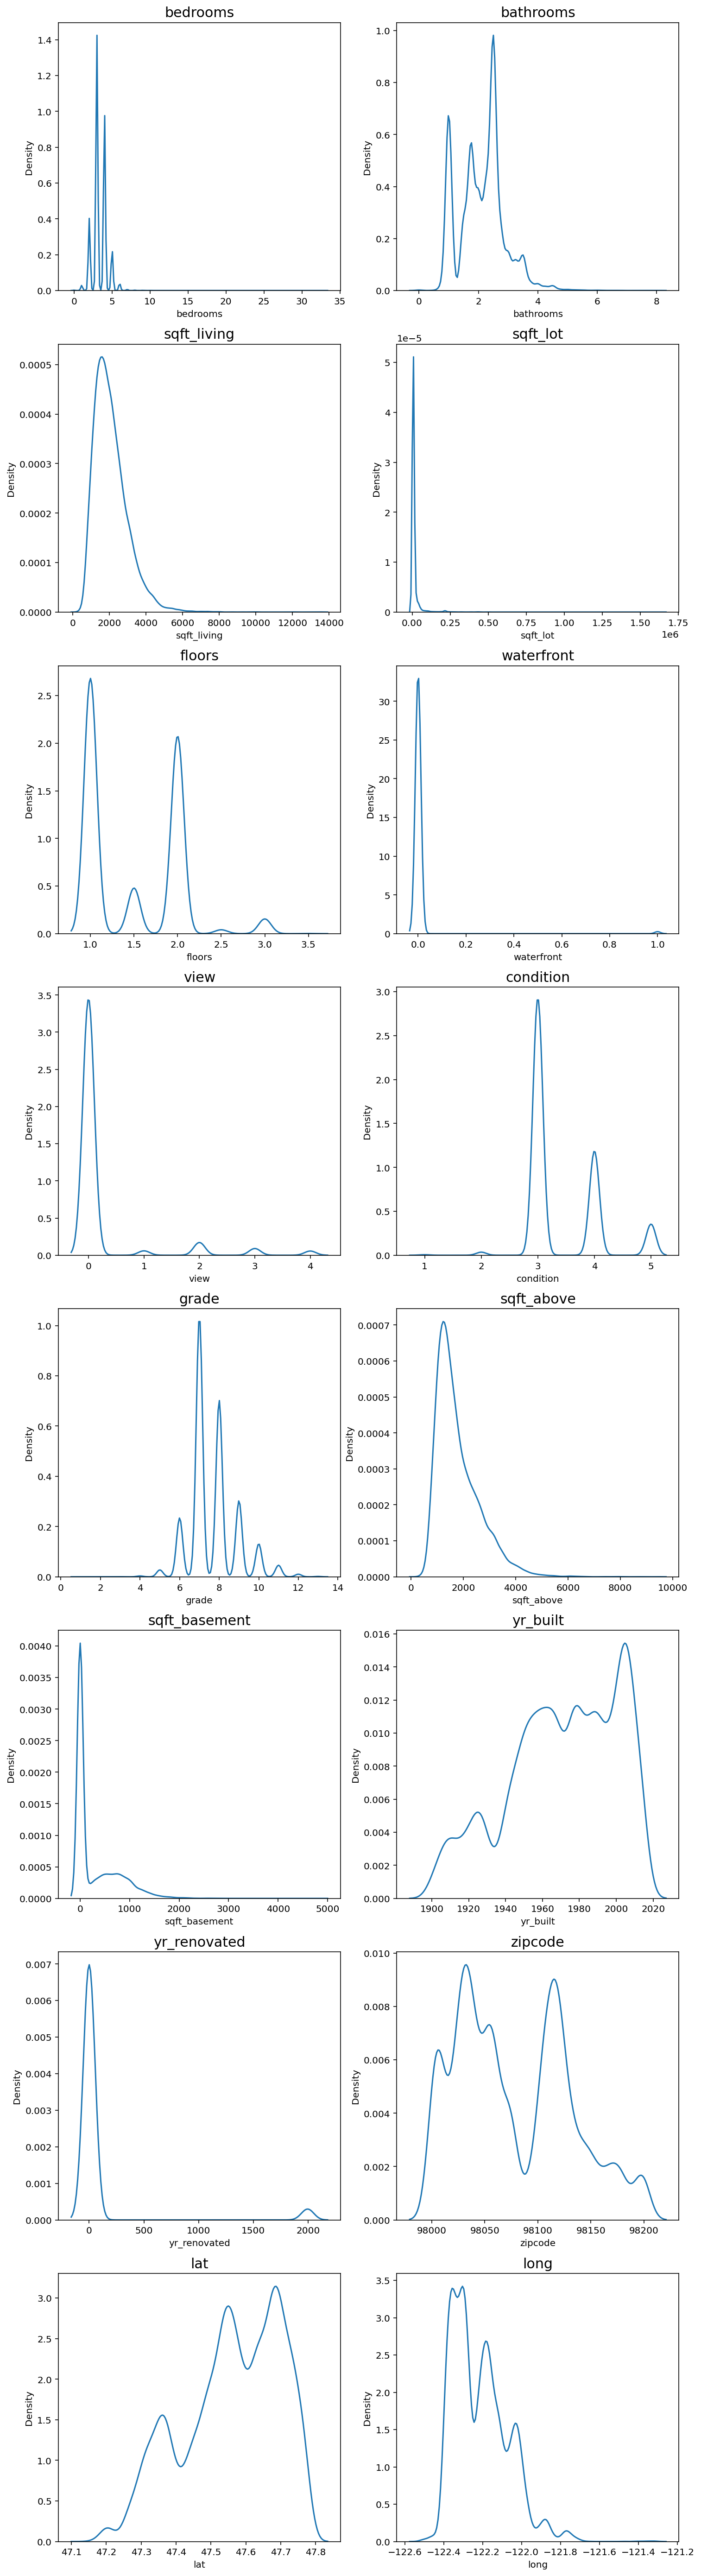

In [17]:
fig, ax = plt.subplots(8, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(8):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 18 :
            break

In [18]:
skew_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

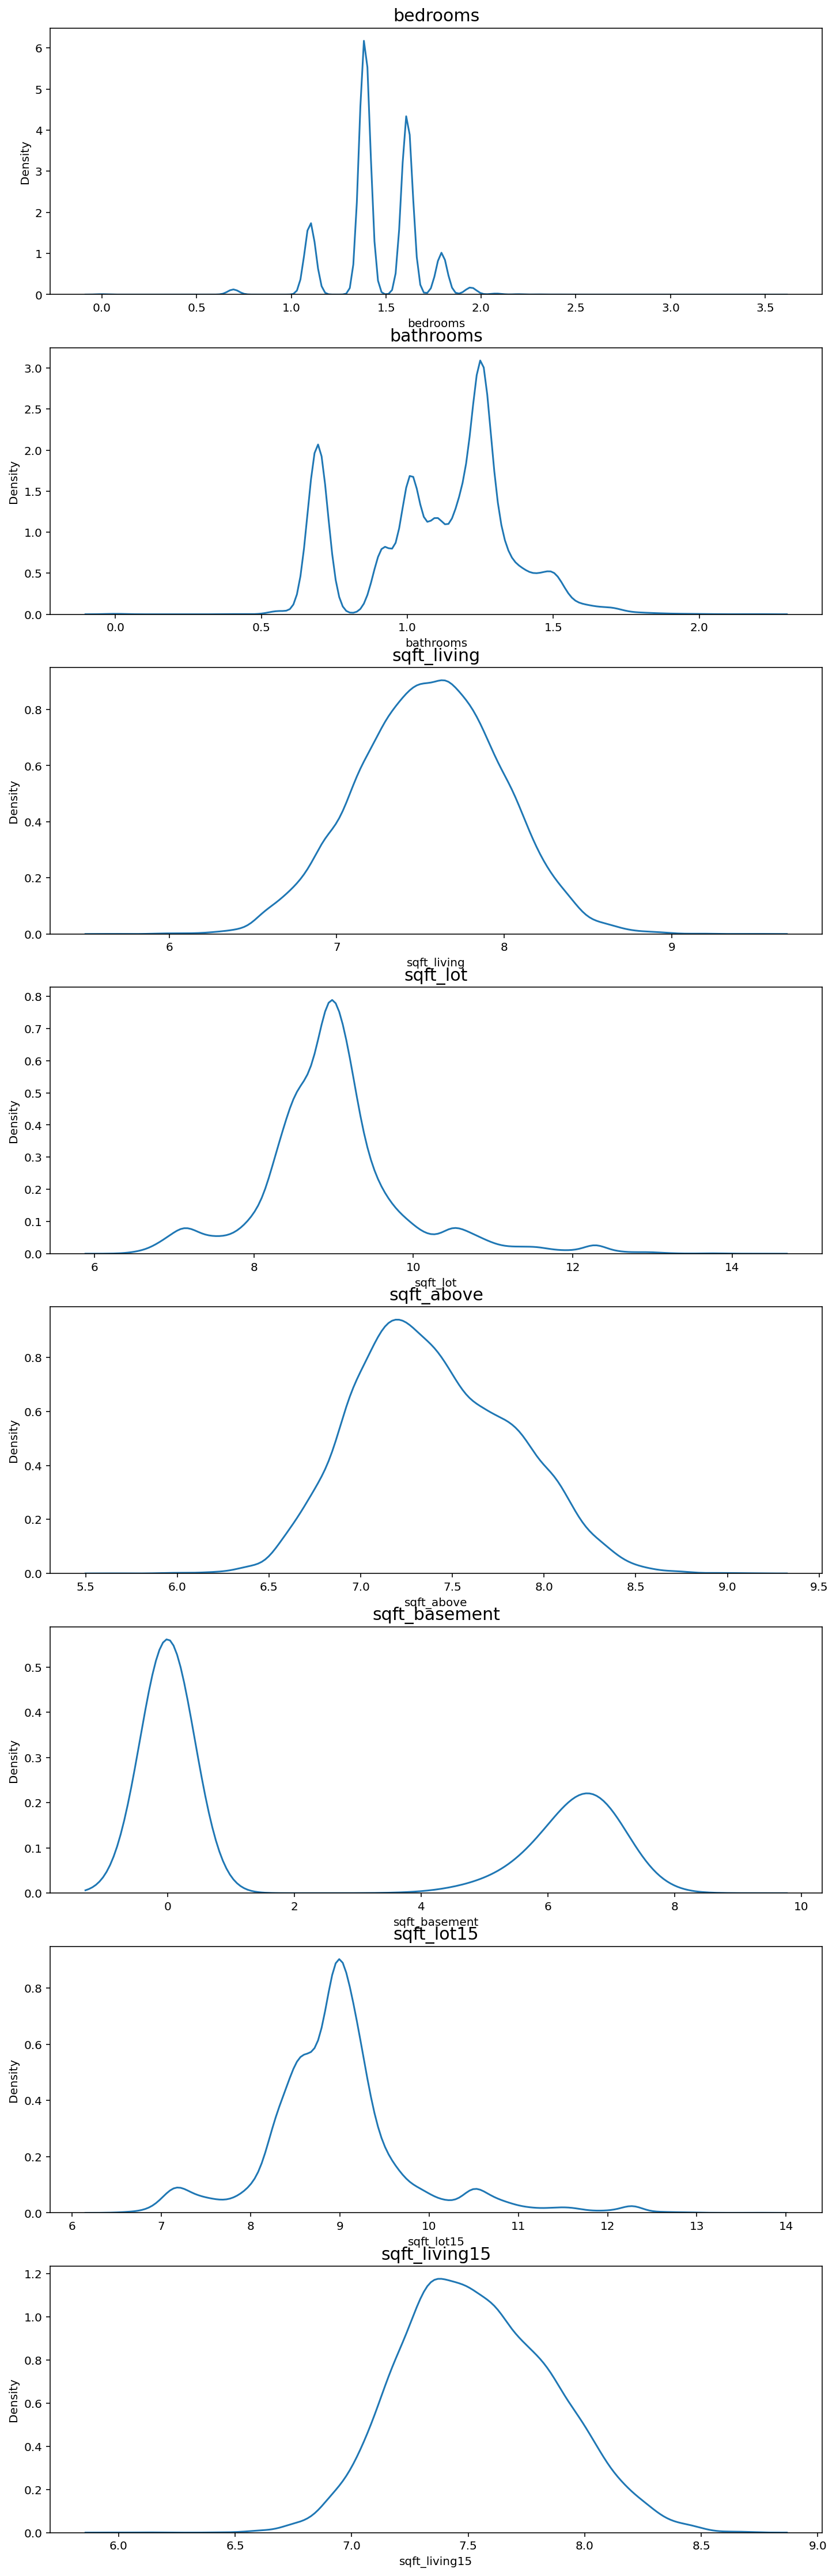

In [19]:
fig, ax = plt.subplots(8, 1, figsize=(12, 40))


for i in range(8):
    sns.kdeplot(data=data[skew_columns[i]], ax=ax[i])
    ax[i].set_title(skew_columns[i], fontsize=15)

In [20]:
# 정규화

standardization = (data[columns]-data[columns].mean())/data[columns].std()
standardization.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,-0.646762,-0.312366,-1.637410,-1.125316,-0.388528,-0.916615,-0.087395,-0.306109,-0.630259,-0.561266,-0.754072,-0.798002,-0.546602,-0.210564,1.871420,-0.352924,-0.306846,-1.035923,-0.395538
1,1.430859,-1.660408,-1.637410,-2.130052,0.243906,-0.916615,-0.087395,-0.306109,-0.630259,-1.412749,-1.751982,-0.798002,-1.295605,-0.210564,-0.932849,1.282539,-0.136432,1.125274,0.041586
2,1.430859,-0.312366,-0.027550,-0.293525,0.007740,-0.916615,-0.087395,-0.306109,-0.630259,0.290216,0.072067,-0.798002,0.542856,-0.210564,-0.072873,0.408897,1.198479,-0.135119,-0.046772
3,-0.737093,-0.312366,0.290252,-0.244971,-0.180217,0.934608,-0.087395,-0.306109,-0.630259,-0.561266,0.120291,-0.798002,0.815221,-0.210564,-1.400227,-1.806588,-0.803888,0.529770,-0.164309
4,1.408276,-0.312366,-0.751440,-1.377778,0.211420,-0.916615,-0.087395,-0.306109,-0.630259,-0.561266,-1.004820,-0.798002,-0.274238,-0.210564,2.245322,-1.086610,-0.718681,-0.400727,0.270417


In [21]:
# 중요하지 않은 데이터 삭제

drop_cols = ['date', 'view', 'condition']

data = data.drop(drop_cols, axis=1)

### y 정규분포로 변환
(로그변환)

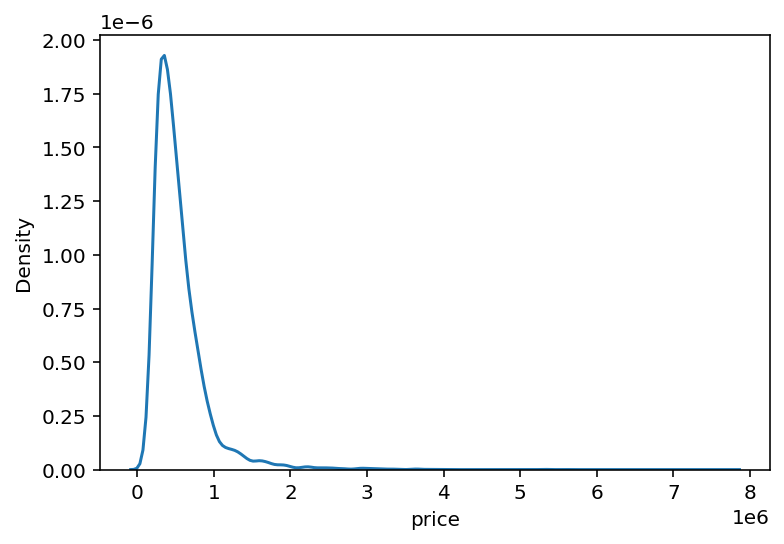

In [22]:
# 타겟 데이터 확인

sns.kdeplot(data=y)
plt.show()

In [23]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

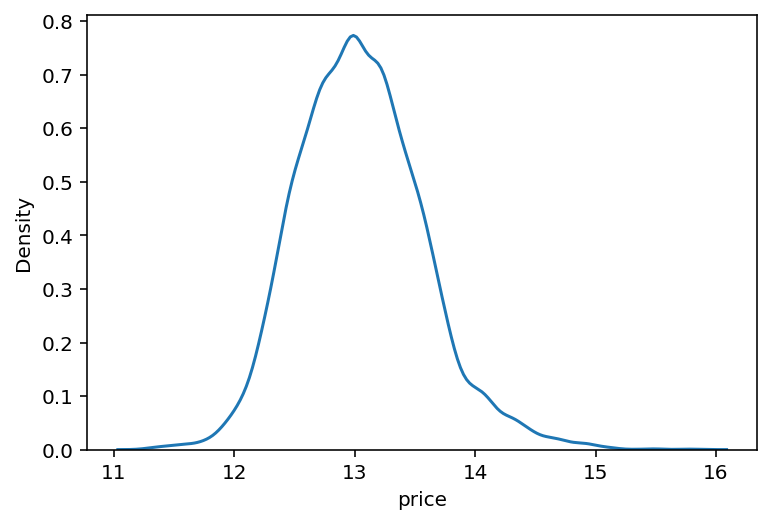

In [24]:
sns.kdeplot(data=y)
plt.show()

### 모델 학습

In [55]:
X = data.iloc[:train_len]
sub = data.iloc[train_len:]

print(X.shape)
print(sub.shape)

(15035, 16)
(6468, 16)


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [40]:
# rmse 계산

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [41]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택  
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [56]:
def get_scores(models, train, y):
    # 답안 작성
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__

    # train, test 데이터셋 분리
    # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=2020)

    # 모델 학습
        model.fit(X_train, y_train)
    
    # 예측
        pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, pred)
    
    # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return df

get_scores(models, X, y)

{'GradientBoostingRegressor': 129671.32974164652,
 'XGBRegressor': 118515.60974137334,
 'LGBMRegressor': 119519.90974784542,
 'RandomForestRegressor': 127131.78518441562}

[CV] END .......................max_depth=1, n_estimators=50; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.0s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.0s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.0s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.1s
[CV] END ...................

### 하이퍼 파라미터 실험하기

In [58]:
# GridSearchCV 활용

from sklearn.model_selection import GridSearchCV

In [67]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

# 코드 입력
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 데이터  분할 (8:2)
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=2020)
    
    # 모델 fitting
    grid_model.fit(X_train, y_train)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [68]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, X, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.029911,0.172949
2,10,50,-0.031271,0.176837
1,1,100,-0.056869,0.238471
0,1,50,-0.074934,0.273741


### 하이퍼 파라미터 조정 2차

In [69]:
# scoring NRMSE로 변경

# 코드 입력
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_root_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 데이터  분할 (8:2)
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=2020)
    
    # 모델 fitting
    grid_model.fit(X_train, y_train)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [64]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [-1, 5, 10],
    'num_leaves': [20, 31, 50],
    'feature_fraction': [0.7, 0.8, 1.0]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, X, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.4s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.4s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=10, n_estimators=50; total time=   1.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.6s
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[CV] END feature_fraction=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=20; total time=   1.4s
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[CV]

KeyboardInterrupt: 

파라미터 설정이 중복 혹은 무시되면 오류 발생

In [70]:
# 파라미터 후보 줄여서 다시 시도

param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [-1, 5, 10]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, X, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
17,0.05,10,500,-0.171056,0.413590
11,0.05,-1,500,-0.171474,0.414094
16,0.05,10,200,-0.172129,0.414884
10,0.05,-1,200,-0.172207,0.414978
25,0.10,10,200,-0.172481,0.415308
14,0.05,5,500,-0.172520,0.415355
19,0.10,-1,200,-0.172645,0.415506
24,0.10,10,100,-0.172908,0.415822
18,0.10,-1,100,-0.173062,0.416007
23,0.10,5,500,-0.173418,0.416435


시도해본 결과 NRMSE는 오히려 결과가 나쁨

In [77]:
# scoring NRMSE로 변경

# 코드 입력
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 데이터  분할 (8:2)
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=2020)
    
    # 모델 fitting
    grid_model.fit(X_train, y_train)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [90]:
# 파라미터 후보 줄여서 다시 시도

param_grid = {
    'n_estimators': [500, 800],
    'learning_rate': [0.01, 0.05],
    'max_depth': [8, 12]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, X, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
6,0.05,12,500,-0.029400,0.171465
3,0.01,12,1000,-0.029441,0.171585
4,0.05,8,500,-0.029451,0.171613
1,0.01,8,1000,-0.029665,0.172236
7,0.05,12,1000,-0.029799,0.172624
5,0.05,8,1000,-0.029855,0.172787
2,0.01,12,500,-0.030906,0.175800
0,0.01,8,500,-0.031202,0.176642


In [92]:
model = LGBMRegressor(max_depth=12, n_estimators=500, learning_rate=0.05, random_state=random_state)
model.fit(X, y)


LGBMRegressor(learning_rate=0.05, max_depth=12, n_estimators=500,
              random_state=2020)

In [94]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

# 코드 작성
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [96]:
save_submission(model, X, y, sub, 'lgbm', rmsle='0.171465')

/aiffel/aiffel/kaggle_kakr_housing/data/data/submission_lgbm_RMSLE_0.171465.csv saved!
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   1.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   1.9s
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=200; total time=   3.7s
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=500; total time=   7.4s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   1.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time=   2.9s
[CV] END ..learning_rate=0.05, max_depth=8, n_estimators=200; total time=   2.4s
[CV] END ..learning_rate=0.05, max_depth=8, n_estimators=500; total time=   6.5s
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=500; total time=   9.0s
[CV] END .learning_rate=0.01, max_depth=8, n_estimators=1000; total time=  13.8s
[CV] END .learning_rate=0.01, max_depth=12, n_estimators=500; total time=   9.2s
[CV] END learning_rate

Kaggle private score : 118598. 모델 파라미터와 데이터 전처리를 더 수정해야 함